### Creación de nuevas variables para SCL LATAM. Clustering.
### Tomando en cuenta el código presentado por Juan en "to-expose.ipynb", en este código inicial se toman el resto de las variables anteriormente creadas, pero no usadas por Juan y se usan las varibles de tasas de atraso, tanto en Destinos como en Aerolineas para crear cluster de destinos y cluster de aerolineas que pudieran mejorar la performance de los modelos ya presentados.

In [1]:
# Lectura de la base de datos

#Se importan las librerías necesarias para el problema
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msng
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

In [2]:
df = pd.read_csv('dataset_SCL.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


Ver las primeras líneas del archivo

In [4]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


#### Generación de nuevasa variables

* **temporada_alta** : 1 si **Fecha-I** está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no

In [5]:
from datetime import datetime

def temporada_alta(fecha):
    fecha_año = int(fecha.split('-')[0])
    fecha = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S')
    range1_min = datetime.strptime('15-Dec', '%d-%b').replace(year = fecha_año)
    range1_max = datetime.strptime('31-Dec', '%d-%b').replace(year = fecha_año)
    range2_min = datetime.strptime('1-Jan', '%d-%b').replace(year = fecha_año)
    range2_max = datetime.strptime('3-Mar', '%d-%b').replace(year = fecha_año)
    range3_min = datetime.strptime('15-Jul', '%d-%b').replace(year = fecha_año)
    range3_max = datetime.strptime('31-Jul', '%d-%b').replace(year = fecha_año)
    range4_min = datetime.strptime('11-Sep', '%d-%b').replace(year = fecha_año)
    range4_max = datetime.strptime('30-Sep', '%d-%b').replace(year = fecha_año)
    
    if ((fecha >= range1_min and fecha <= range1_max) or 
        (fecha >= range2_min and fecha <= range2_max) or 
        (fecha >= range3_min and fecha <= range3_max) or
        (fecha >= range4_min and fecha <= range4_max)):
        return 1
    else:
        return 0

In [6]:
# Se añade la nueva variable al dataframe (df)

df['temporada_alta'] = df['Fecha-I'].apply(temporada_alta)

In [7]:
# Conteo de temporada alta

df['temporada_alta'].value_counts()

0    46174
1    22032
Name: temporada_alta, dtype: int64

* **dif_min** : diferencia en minutos entre **Fecha-O** y **Fecha-I** . Con esta variable se construirá la variable a modelar.

In [8]:
def dif_min(data):
    fecha_o = datetime.strptime(data['Fecha-O'], '%Y-%m-%d %H:%M:%S')
    fecha_i = datetime.strptime(data['Fecha-I'], '%Y-%m-%d %H:%M:%S')
    dif_min = ((fecha_o - fecha_i).total_seconds())/60
    return dif_min        

In [9]:
# Se añade la nueva variable al dataframe (df)

df['dif_min'] = df.apply(dif_min, axis = 1)

### Creación de TARGET

* **atraso_15** : 1 si **dif_min** > 15, 0 si no. Se añade a df

In [10]:
df['atraso_15'] = np.where(df['dif_min'] > 15, 1, 0)

In [11]:
# Se puede apreciar que es un problema desbalanceado

df['atraso_15'].value_counts()

0    55592
1    12614
Name: atraso_15, dtype: int64

* **periodo_dia** : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a **Fecha-I**.

In [12]:
def get_periodo_dia(fecha):
    fecha_time = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S').time()
    mañana_min = datetime.strptime("05:00", '%H:%M').time()
    mañana_max = datetime.strptime("11:59", '%H:%M').time()
    tarde_min = datetime.strptime("12:00", '%H:%M').time()
    tarde_max = datetime.strptime("18:59", '%H:%M').time()
    noche_min1 = datetime.strptime("19:00", '%H:%M').time()
    noche_max1 = datetime.strptime("23:59", '%H:%M').time()
    noche_min2 = datetime.strptime("00:00", '%H:%M').time()
    noche_max2 = datetime.strptime("4:59", '%H:%M').time()
    
    if(fecha_time > mañana_min and fecha_time < mañana_max):
        return 'mañana'
    elif(fecha_time > tarde_min and fecha_time < tarde_max):
        return 'tarde'
    elif((fecha_time > noche_min1 and fecha_time < noche_max1) or
         (fecha_time > noche_min2 and fecha_time < noche_max2)):
        return 'noche'

In [13]:
# Se añade periodo dia al df

df['periodo_dia'] = df['Fecha-I'].apply(get_periodo_dia)

Veamos las primeras líneas del dataframe "df" y sus nuevas variables.

In [14]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0,noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0,noche
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,0,noche
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,0,noche


### Creación de la función para el cálculo de Tasa de Atraso

In [15]:
def calcular_tasa(df, columna):
    
    dic_atrasos = {}
    for _, row in df.iterrows():
        if row['atraso_15'] == 1:
            if row[columna] not in dic_atrasos:
                dic_atrasos[row[columna]] = 1
            else:
                dic_atrasos[row[columna]] += 1
    
    total_values = df[columna].value_counts()
    
    dic_tasas = {}
    for name, total in total_values.iteritems():
        if name in dic_atrasos:
            dic_tasas[name] = round(total / dic_atrasos[name], 2)
        else:
            dic_tasas[name] = 0
            
    return pd.DataFrame.from_dict(data = dic_tasas, orient = 'index', columns = ['Tasa (%)'])

### Creación de Tasa de Atraso para Cluster de Destinos y Aerolineas

In [16]:
tasas_destinos = calcular_tasa(df, 'SIGLADES')
tasas_destinos

,Tasa (%)
Buenos Aires,3.91
Antofagasta,6.83
Lima,4.34
Calama,8.18
Puerto Montt,5.94
...,...
Quito,1.00
Washington,0.00
"Pisco, Peru",0.00
Puerto Stanley,1.00


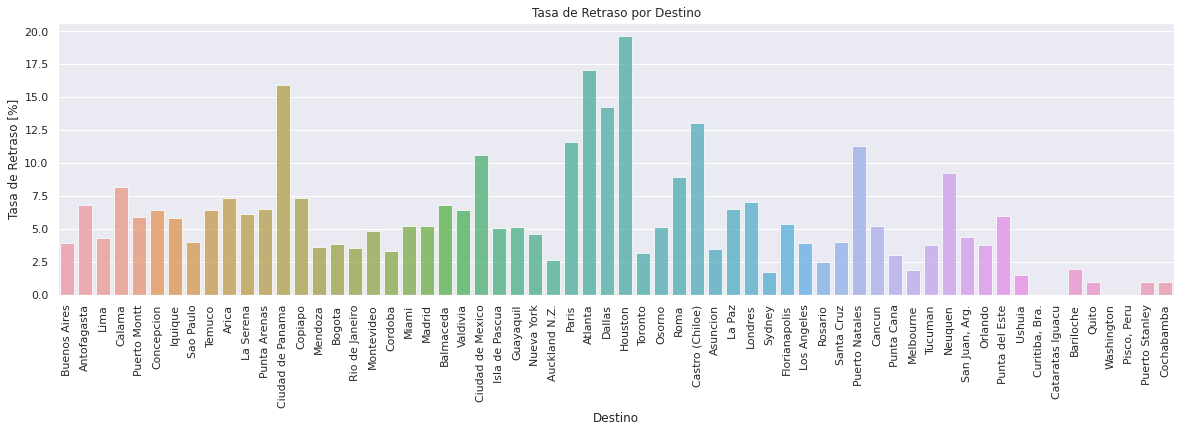

In [17]:
tasas_destinos_values = df['SIGLADES'].value_counts().index
plt.figure(figsize = (20,5))
sns.set(style="darkgrid")
sns.barplot(df['SIGLADES'].value_counts().index, tasas_destinos['Tasa (%)'], alpha = 0.75)
plt.title('Tasa de Retraso por Destino')
plt.ylabel('Tasa de Retraso [%]', fontsize=12)
plt.xlabel('Destino', fontsize=12)
plt.xticks(rotation=90)
plt.show()

Claramente se aprecia en el gráfico, que los destinos como Ciudad de Panamá, Atlanta, Dallas, Houston tienen altas tasas de atraso. Se intentará hacer cluster. 

In [18]:
tasas_aerolineas = calcular_tasa(df, 'OPERA')
tasas_aerolineas

,Tasa (%)
Grupo LATAM,5.60
Sky Airline,5.63
Aerolineas Argentinas,4.16
Copa Air,15.95
Latin American Wings,2.46
Avianca,3.76
JetSmart SPA,5.59
Gol Trans,2.81
American Airlines,14.84
Air Canada,2.19


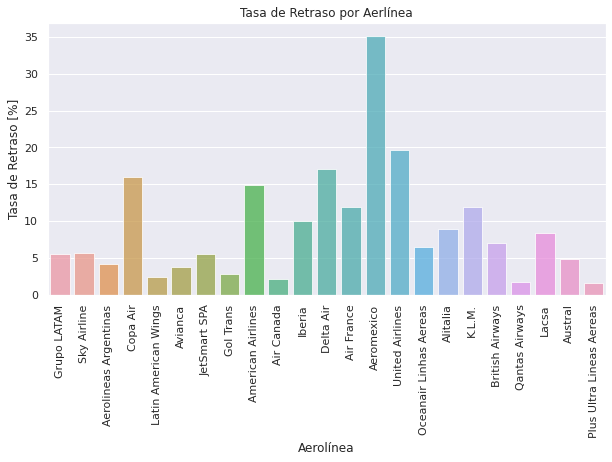

In [19]:
tasas_aerolineas_values = df['OPERA'].value_counts().index

plt.figure(figsize = (10,5))
sns.set(style="darkgrid")
sns.barplot(tasas_aerolineas_values, tasas_aerolineas['Tasa (%)'], alpha = 0.75)
plt.title('Tasa de Retraso por Aerlínea')
plt.ylabel('Tasa de Retraso [%]', fontsize=12)
plt.xlabel('Aerolínea', fontsize=12)
plt.xticks(rotation=90)
plt.show()

Se aprecia que Aeroméxico es un outlier entre los destinos y que Copa Air, American Airlines, Delta Air y United Airlines, pudieran formar un cluster.

In [20]:
# Se crea un dataframe para tasas_destinos

tasas_destinos = calcular_tasa(df, 'SIGLADES')
df[tasas_destinos]
print(tasas_destinos)

                Tasa (%)
Buenos Aires        3.91
Antofagasta         6.83
Lima                4.34
Calama              8.18
Puerto Montt        5.94
...                  ...
Quito               1.00
Washington          0.00
Pisco, Peru         0.00
Puerto Stanley      1.00
Cochabamba          1.00

[62 rows x 1 columns]


In [21]:
# Se crea un dataframe para tasas_aerolineas

tasas_aerolineas = calcular_tasa(df, 'OPERA')
tasas_aerolineas
print(tasas_aerolineas)

                          Tasa (%)
Grupo LATAM                   5.60
Sky Airline                   5.63
Aerolineas Argentinas         4.16
Copa Air                     15.95
Latin American Wings          2.46
Avianca                       3.76
JetSmart SPA                  5.59
Gol Trans                     2.81
American Airlines            14.84
Air Canada                    2.19
Iberia                       10.06
Delta Air                    17.05
Air France                   11.93
Aeromexico                   35.10
United Airlines              19.71
Oceanair Linhas Aereas        6.49
Alitalia                      8.93
K.L.M.                       11.95
British Airways               7.07
Qantas Airways                1.73
Lacsa                         8.36
Austral                       4.93
Plus Ultra Lineas Aereas      1.63


Ahora se harán cluster para estas dos variables por separado.
Debido a que son pocos los sujetos de análisis tanto en destinos como en aerolineas y que es más fácil determinar el número de cluster, se recurrirá al famoso y antiguo cluster jerárquico usando distancia euclidea al cuadrado y el método Ward para las uniones.

In [22]:
# Importamos librerías necesarias

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [23]:
# Partimos con el cluster de tasas_destinos

tasas_destinos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, Buenos Aires to Cochabamba
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tasa (%)  62 non-null     float64
dtypes: float64(1)
memory usage: 3.0+ KB


In [24]:
# tasas_destinos

data_cluster_destinos = tasas_destinos.iloc[:, [0]].values
data_cluster_destinos

array([[ 3.91],
       [ 6.83],
       [ 4.34],
       [ 8.18],
       [ 5.94],
       [ 6.41],
       [ 5.85],
       [ 4.05],
       [ 6.42],
       [ 7.38],
       [ 6.18],
       [ 6.5 ],
       [15.95],
       [ 7.36],
       [ 3.67],
       [ 3.87],
       [ 3.54],
       [ 4.85],
       [ 3.32],
       [ 5.24],
       [ 5.26],
       [ 6.82],
       [ 6.44],
       [10.61],
       [ 5.08],
       [ 5.15],
       [ 4.66],
       [ 2.67],
       [11.58],
       [17.05],
       [14.28],
       [19.65],
       [ 3.18],
       [ 5.18],
       [ 8.93],
       [13.06],
       [ 3.52],
       [ 6.53],
       [ 7.07],
       [ 1.72],
       [ 5.4 ],
       [ 3.97],
       [ 2.52],
       [ 4.  ],
       [11.29],
       [ 5.25],
       [ 3.  ],
       [ 1.86],
       [ 3.8 ],
       [ 9.25],
       [ 4.38],
       [ 3.78],
       [ 6.  ],
       [ 1.5 ],
       [ 0.  ],
       [ 0.  ],
       [ 2.  ],
       [ 1.  ],
       [ 0.  ],
       [ 0.  ],
       [ 1.  ],
       [ 1.  ]])

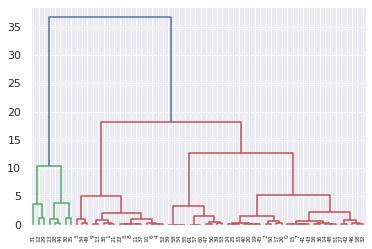

In [26]:
C_J_destinos = linkage(data_cluster_destinos, 'ward') # Utilizamos el método Ward para agrupar.
dendrogram = sch.dendrogram(C_J_destinos)

In [27]:
# Creamos los clusters (3 segmentos)

clusters_destinos = fcluster(C_J_destinos, t=15, criterion='distance') # t es la altura a la cual se hará el corte y que generará 3 cluster
clusters_destinos

array([3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 2, 1, 3, 2, 2, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [28]:
# Se añade el cluster al destino

tasas_destinos['C_J_destinos'] = clusters_destinos
tasas_destinos

,Tasa (%),C_J_destinos
Buenos Aires,3.91,3
Antofagasta,6.83,2
Lima,4.34,3
Calama,8.18,2
Puerto Montt,5.94,2
...,...,...
Quito,1.00,3
Washington,0.00,3
"Pisco, Peru",0.00,3
Puerto Stanley,1.00,3


In [29]:
# Tasas de atraso medias por cluster

media_grupo_destinos = tasas_destinos.groupby('C_J_destinos').mean()
media_grupo_destinos

,Tasa (%)
C_J_destinos,
1,14.183750
2,6.946471
3,3.180270


In [30]:
# Seguimos con el cluster de tasas_aerolineas

tasas_aerolineas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, Grupo LATAM to Plus Ultra Lineas Aereas
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tasa (%)  23 non-null     float64
dtypes: float64(1)
memory usage: 368.0+ bytes


In [31]:
# tasas_aerolineas

data_cluster_aerolineas = tasas_aerolineas.iloc[:, [0]].values
data_cluster_aerolineas

array([[ 5.6 ],
       [ 5.63],
       [ 4.16],
       [15.95],
       [ 2.46],
       [ 3.76],
       [ 5.59],
       [ 2.81],
       [14.84],
       [ 2.19],
       [10.06],
       [17.05],
       [11.93],
       [35.1 ],
       [19.71],
       [ 6.49],
       [ 8.93],
       [11.95],
       [ 7.07],
       [ 1.73],
       [ 8.36],
       [ 4.93],
       [ 1.63]])

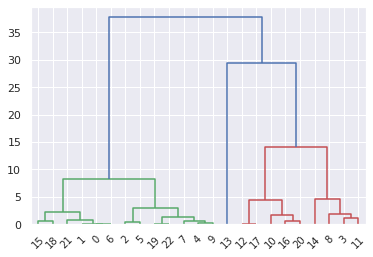

In [32]:
C_J_aerolineas = linkage(data_cluster_aerolineas, 'ward') # Utilizamos el método Ward para agrupar.
dendrogram = sch.dendrogram(C_J_aerolineas)

In [34]:
# Creamos los clusters (5 segmentos). Tal como se había mencionado, Aeroméxico descolla.

clusters_aerolineas = fcluster(C_J_aerolineas, t=5, criterion='distance') # t es la altura a la cual se hará el corte
clusters_aerolineas

array([1, 1, 2, 4, 2, 2, 1, 2, 4, 2, 3, 4, 3, 5, 4, 1, 3, 3, 1, 2, 3, 1,
       2], dtype=int32)

In [35]:
# Se añade el cluster a la aerolinea

tasas_aerolineas['C_J_aerolineas'] = clusters_aerolineas
tasas_aerolineas

,Tasa (%),C_J_aerolineas
Grupo LATAM,5.60,1
Sky Airline,5.63,1
Aerolineas Argentinas,4.16,2
Copa Air,15.95,4
Latin American Wings,2.46,2
Avianca,3.76,2
JetSmart SPA,5.59,1
Gol Trans,2.81,2
American Airlines,14.84,4
Air Canada,2.19,2


In [36]:
# Tasas de atraso medias por cluster

media_grupo_aerolineas = tasas_aerolineas.groupby('C_J_aerolineas').mean()
media_grupo_aerolineas

,Tasa (%)
C_J_aerolineas,
1,5.885000
2,2.677143
3,10.246000
4,16.887500
5,35.100000


Ahora unimos las variables de los clusters de destinos y de los clusters aerolineas al dataframe features

In [37]:
# Tomamos las variables antiguas y nuevas y creamos mf

mf = df[['OPERA', 'MES', 'TIPOVUELO', 'SIGLADES', 'DIANOM', 'temporada_alta','periodo_dia', 'atraso_15']]

In [38]:
mf.head()

,OPERA,MES,TIPOVUELO,SIGLADES,DIANOM,temporada_alta,periodo_dia,atraso_15
0,American Airlines,1,I,Miami,Domingo,1,noche,0
1,American Airlines,1,I,Miami,Lunes,1,noche,0
2,American Airlines,1,I,Miami,Martes,1,noche,0
3,American Airlines,1,I,Miami,Miercoles,1,noche,0
4,American Airlines,1,I,Miami,Jueves,1,noche,0


In [39]:
mf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   OPERA           68206 non-null  object
 1   MES             68206 non-null  int64 
 2   TIPOVUELO       68206 non-null  object
 3   SIGLADES        68206 non-null  object
 4   DIANOM          68206 non-null  object
 5   temporada_alta  68206 non-null  int64 
 6   periodo_dia     66976 non-null  object
 7   atraso_15       68206 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 4.2+ MB


Añadimos a este df las nuevas varibles

In [40]:
# Eliminaremos la columna Tasa (%) de tasas_destinos

tasas_destinos = tasas_destinos.drop(columns = ["Tasa (%)"])
tasas_destinos.head()

,C_J_destinos
Buenos Aires,3
Antofagasta,2
Lima,3
Calama,2
Puerto Montt,2


In [41]:
# Unimos tasas_destinos con el dataframe mf

mf = pd.merge(mf, tasas_destinos, left_on="SIGLADES", right_index=True)

In [42]:
# Eliminaremos la columna Tasa (%) de tasas_aerolineas

tasas_aerolineas = tasas_aerolineas.drop(columns = ["Tasa (%)"])
tasas_aerolineas.head()

,C_J_aerolineas
Grupo LATAM,1
Sky Airline,1
Aerolineas Argentinas,2
Copa Air,4
Latin American Wings,2


In [43]:
# Unimos tasas_aerolineas con el dataframe mf

mf = pd.merge(mf, tasas_aerolineas, left_on="OPERA", right_index=True)
mf.head()

,OPERA,MES,TIPOVUELO,SIGLADES,DIANOM,temporada_alta,periodo_dia,atraso_15,C_J_destinos,C_J_aerolineas
0,American Airlines,1,I,Miami,Domingo,1,noche,0,3,4
1,American Airlines,1,I,Miami,Lunes,1,noche,0,3,4
2,American Airlines,1,I,Miami,Martes,1,noche,0,3,4
3,American Airlines,1,I,Miami,Miercoles,1,noche,0,3,4
4,American Airlines,1,I,Miami,Jueves,1,noche,0,3,4


In [46]:
# Desordenamos mf 
from sklearn.utils import shuffle

mf = shuffle(mf, random_state = 123)

In [47]:
# Grabamos la base de datos para aplicar otros algoritmos

mf.to_csv('dataset_SCL_2.csv', index = False) 

Ahora, el archivo de trabajo o "vista minable", será el archivo dataset_SCL_2, el cual contiene las variables creadas por Juan, pero no usadas y los 2 nuevos clusters. Esperemos que ellas ayuden a mejorar los desempeños de los modelos.